# Social Follow Up
## Analysis

The first study, called `social-follow-up`, first replicated the results of the first study on a different set of randomly chosen question. We then extend the questions asked in the first study to explore where the social influence on participants curiousity were reflected in their desire to the see the answers of questions.

In [1]:
%load_ext pycodestyle_magic

In [2]:
# Analytical Tools
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Utilities
import math
import json
import pprint
import importlib
import utilities.processing as processing
import utilities.plotting as plotting
import utilities.describe as describe

# Make printing much more convenient
log = pprint.pprint

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Loading Data

In [3]:
FILE_NAMES = [
    'raw-data/question-setup-social-follow-up.json',
    'raw-data/social-follow-up-entries.json'
]

with open(FILE_NAMES[0]) as file:
    literals = json.load(file)

q_text = literals['questions_and_answers']['questions']
j_text = literals['judgements']
QUESTIONS = {ques: 'q' + str(num) for num, ques in enumerate(q_text)}
JUDGEMENTS = {judge: 'j' + str(num) for num, judge in enumerate(j_text)}

In [4]:
with open(FILE_NAMES[1]) as file:
    master_responses = [json.loads(line) for line in file if line]
# Legacy, changing variable name
real_responses = master_responses
len(real_responses)

110

### Reading Responses into Data
Creates a `DataFrame` based on the survey data.

In [5]:
# Create dictionary to represent future DataFrame
num_questions = len(QUESTIONS)
num_judgements = len(JUDGEMENTS)
col_labels = processing.get_col_labels(num_questions,
                                       num_judgements,
                                       choice=True)
data = {label: [] for label in col_labels}

In [6]:
processing.fill_social_follow_up_data(data,
                                      real_responses,
                                      QUESTIONS,
                                      JUDGEMENTS)

In [7]:
data = pd.DataFrame(data)
print(data.size)
data.head()

7920


,condition,consent,q0choice,q0j0,q0j1,q0j2,q0j3,q0j4,q0score,q1choice,...,q8j3,q8j4,q8score,q9choice,q9j0,q9j1,q9j2,q9j3,q9j4,q9score
0,B,1,1,5,4,5,2,3,22,1,...,6,6,3375,0,4,4,2,4,4,3370
1,B,1,0,0,0,0,4,0,5,0,...,3,5,3375,1,0,0,0,3,5,3394
2,A,1,0,3,3,4,4,4,3365,1,...,3,3,38,1,3,2,5,4,5,36
3,B,1,1,3,0,0,4,0,36,0,...,5,5,3364,1,1,0,0,3,3,3365
4,B,1,0,0,0,3,5,1,40,0,...,2,2,3359,0,2,0,4,6,6,3360


### Preparing Data for Analysis

We first split the data into two groups, one corresponding to those which received high scores for group A and one for those who received higher scores for group B. The groups themselves are in the constant section for reference, where the first five entries corresponding to group A and the last five to group B.

In [8]:
# Remove participants without consent
data = data[data.consent == 1]
print(data.size, len(data))
# Creates useful lists
sorted_question_labels = sorted(QUESTIONS.values())
judgements_labels = sorted(JUDGEMENTS.values())
group_a_question_labels = sorted_question_labels[:5]
group_b_question_labels = sorted_question_labels[5:]

7920 110


In [9]:
# Insert group a and b averages for each person
for j_num in judgements_labels:
    group_a_columns = [q_num + j_num for q_num in group_a_question_labels]
    group_b_columns = [q_num + j_num for q_num in group_b_question_labels]
    group_a_averages = data[group_a_columns].mean(axis=1)
    group_b_averages = data[group_b_columns].mean(axis=1)
    data['{}_a_avg'.format(j_num)] = group_a_averages
    data['{}_b_avg'.format(j_num)] = group_b_averages
data.head()

,condition,consent,q0choice,q0j0,q0j1,q0j2,q0j3,q0j4,q0score,q1choice,...,j0_a_avg,j0_b_avg,j1_a_avg,j1_b_avg,j2_a_avg,j2_b_avg,j3_a_avg,j3_b_avg,j4_a_avg,j4_b_avg
0,B,1,1,5,4,5,2,3,22,1,...,4.6,4.6,3.6,3.2,4.2,3.8,4.0,4.2,2.6,4.2
1,B,1,0,0,0,0,4,0,5,0,...,0.8,0.6,0.0,0.0,0.0,0.2,4.2,4.4,0.0,5.0
2,A,1,0,3,3,4,4,4,3365,1,...,4.0,4.0,4.2,2.6,4.6,4.4,4.6,4.0,3.8,4.0
3,B,1,1,3,0,0,4,0,36,0,...,1.6,1.4,0.0,0.0,0.0,0.0,3.6,3.6,0.4,3.0
4,B,1,0,0,0,3,5,1,40,0,...,2.6,3.0,0.0,0.0,3.0,3.8,4.6,3.6,0.6,5.2


In [10]:
# Seperate into dataframes for each condition!
high_a = data[data.condition == 'A']
high_b = data[data.condition == 'B']
a_size, b_size = len(high_a), len(high_b)
a_size, b_size

(59, 51)

### Paired Samples Test

We first attempt to replicate the results of the first experiment by once again conducting a paired samples t-test.

Usefulness: t = -1.2, p = 0.231 (1 greater)
Confidence: t = -0.791, p = 0.43 (1 greater)
Curiosity: t = -4.86, p = 3.99e-06 (1 greater)
Writing: t = -4.03, p = 0.000102 (1 greater)
Popularity: t = -12.1, p = 6.28e-22 (1 greater)


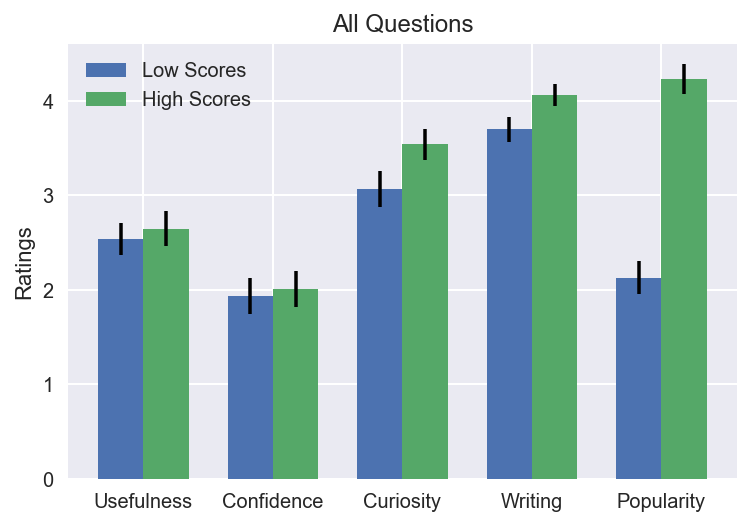

In [11]:
PLOTTING_OPTIONS = {
    'y_label': 'Ratings',
    'ticks': ['Usefulness', 'Confidence', 'Curiosity',
              'Writing', 'Popularity'],
    'legend': ['Low Scores', 'High Scores'],
    'title': 'All Questions'
}

high_avg, high_err = [], []
low_avg, low_err = [], []
for index, j_num in enumerate(judgements_labels):
    all_high_points = np.concatenate((high_a['{}_a_avg'.format(j_num)],
                                      high_b['{}_b_avg'.format(j_num)]))
    all_low_points = np.concatenate((high_a['{}_b_avg'.format(j_num)],
                                     high_b['{}_a_avg'.format(j_num)]))
    high_avg.append(all_high_points.mean())
    high_err.append(all_high_points.std() / math.sqrt(a_size))
    low_avg.append(all_low_points.mean())
    low_err.append(all_low_points.std() / math.sqrt(b_size))

    print('{}: {}'.format(PLOTTING_OPTIONS['ticks'][index],
                          describe.paired_t_test(all_low_points,
                                                 all_high_points)))

plotting.plot_double_bar(low_avg, low_err, high_avg, high_err,
                         **PLOTTING_OPTIONS)

### Simple Choice Comparison

We now do a naive analysis on the effect upvotes have on people by first examining the proportion of question chosen and comparing this to chance with a t-test. Note this treates the variance between questions as noise.

In [14]:
a_choice_labels = ['{}choice'.format(ques) for ques in group_a_question_labels]
b_choice_labels = ['{}choice'.format(ques) for ques in group_b_question_labels]
all_high_chosen_proportion = np.concatenate((
    high_a[a_choice_labels].mean(axis=1),
    high_b[b_choice_labels].mean(axis=1)
))

print(all_high_chosen_proportion.mean())
print(describe.one_sample_t_test(all_high_chosen_proportion, 0.5))

0.576363636364
t = 4.52, p = 1.56e-05 (greater)
